In [1]:
import jax
import jax.numpy as np
import jax.scipy as scipy

In [2]:
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
sns.set(rc={'figure.figsize':(10, 7)})

In [3]:
key = jax.random.PRNGKey(0)

/Users/william/Library/Caches/pypoetry/virtualenvs/graphical-models-gBEl7DCY-py3.8/lib/python3.8/site-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [4]:
n = 500
k = 10

In [5]:
locs = np.linspace(-5, 5, k)
scales = jax.random.uniform(key, (k,)) * 0.1 + 0.1
params = np.stack((locs, scales), axis=0)

weights = jax.random.dirichlet(key, alpha=np.ones((k,)))
weights_logits = scipy.special.logit(weights)

k, locs, scales, params, weights, weights_logits

(10,
 DeviceArray([-5.        , -3.8888888 , -2.7777777 , -1.6666665 ,
              -0.55555534,  0.5555558 ,  1.666667  ,  2.7777781 ,
               3.8888893 ,  5.        ], dtype=float32),
 DeviceArray([0.1354905 , 0.16041991, 0.14275843, 0.1230616 , 0.13298586,
              0.14395365, 0.12509976, 0.12773058, 0.17678207, 0.17147458],            dtype=float32),
 DeviceArray([[-5.        , -3.8888888 , -2.7777777 , -1.6666665 ,
               -0.55555534,  0.5555558 ,  1.666667  ,  2.7777781 ,
                3.8888893 ,  5.        ],
              [ 0.1354905 ,  0.16041991,  0.14275843,  0.1230616 ,
                0.13298586,  0.14395365,  0.12509976,  0.12773058,
                0.17678207,  0.17147458]], dtype=float32),
 DeviceArray([0.12063298, 0.18545808, 0.01005197, 0.00247753, 0.09393217,
              0.11406963, 0.258528  , 0.16325839, 0.02784837, 0.02374289],            dtype=float32),
 DeviceArray([-1.9864496, -1.4797971, -4.589884 , -5.9980135, -2.2665412,
           

In [6]:
mixture_assignments = jax.random.categorical(key, weights_logits, shape=(n,))

In [7]:
gaussians = jax.random.normal(key, shape=(n,))

In [8]:
@jax.jit
def sample_separately(mixture_assignments, gaussians, locs, scales):
    return gaussians * scales.take(mixture_assignments) + locs.take(mixture_assignments)

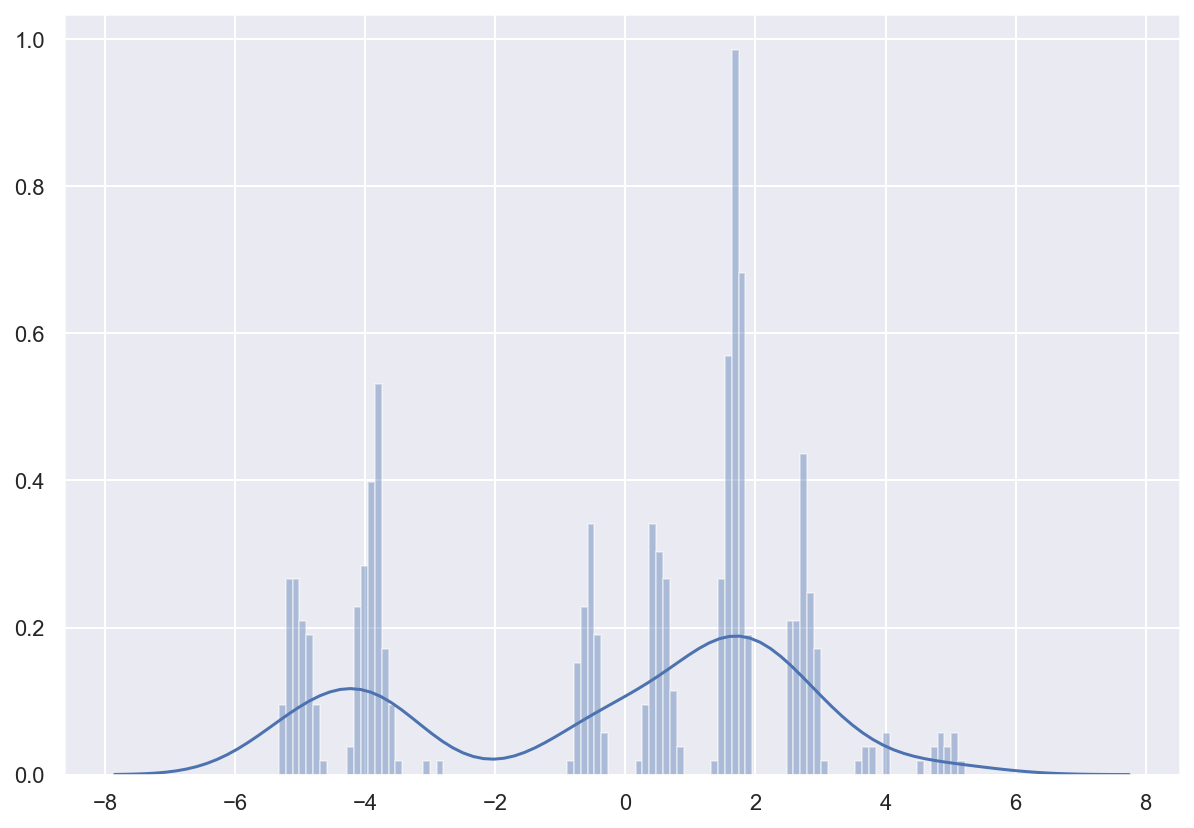

In [9]:
x = sample_separately(mixture_assignments, gaussians, locs, scales)
sns.distplot(x, bins=100)

In [18]:
%timeit sample_separately(mixture_assignments, gaussians, locs, scales).block_until_ready()

185 µs ± 11.9 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [11]:
@jax.jit
def sample_with_params(mixture_assignments, gaussians, params):
    x_params = params.take(mixture_assignments, axis=1)
#     return gaussians * x_params[1] + x_params[0]
    multiplicand = np.stack((gaussians, np.ones_like(gaussians)))
    return np.dot(x_params, multiplicand)

In [12]:
x = sample_with_params(mixture_assignments, gaussians, params)
sns.distplot(x, bins=100)

TypeError: Incompatible shapes for dot: got (2, 500) and (2, 500).

In [ ]:
%timeit sample_with_params(mixture_assignments, gaussians, params).block_until_ready()

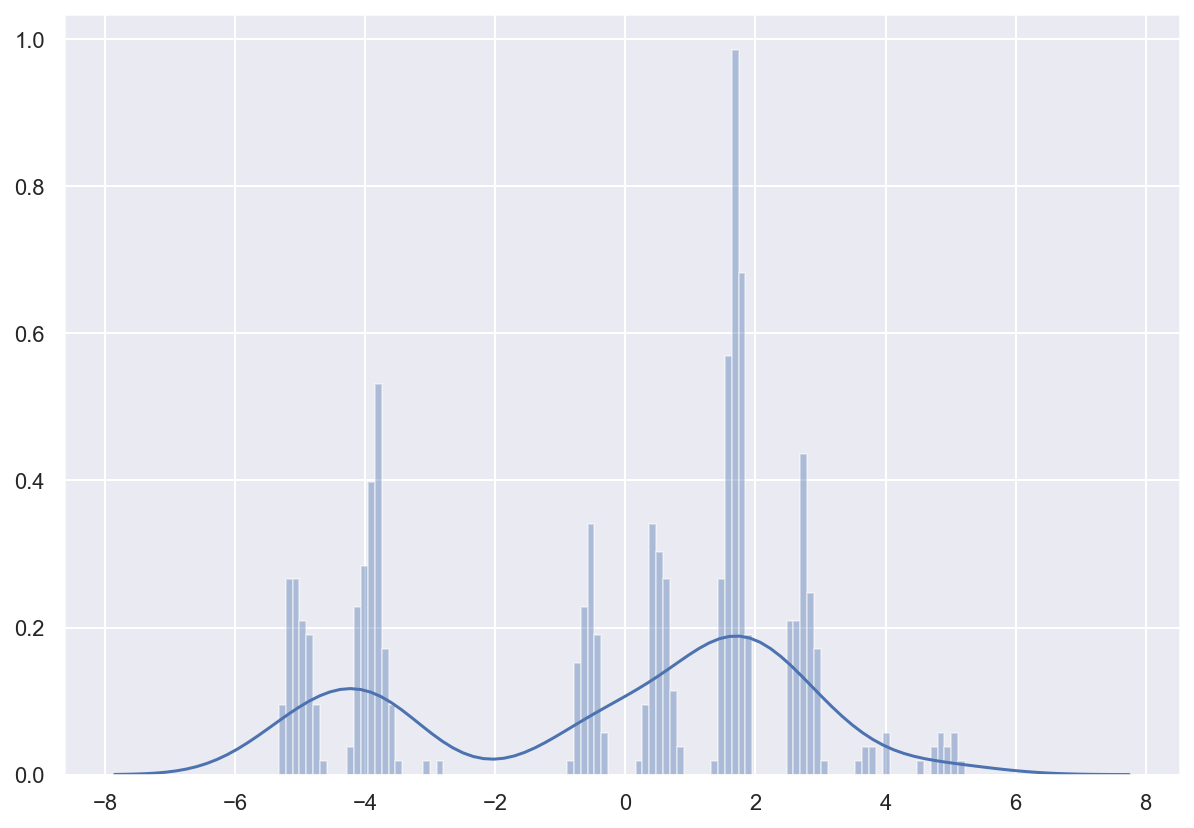

In [15]:
@jax.jit
def sample_params_sum(mixture_assignments, gaussians, params):
    a = jax.numpy.stack((jax.numpy.ones_like(gaussians), gaussians))
    b = params.take(mixture_assignments, axis=1)
    return jax.numpy.sum(a * b, axis=0)

x = sample_params_sum(mixture_assignments, gaussians, params)
sns.distplot(x, bins=100)

In [16]:
%timeit sample_params_sum(mixture_assignments, gaussians, params).block_until_ready()

182 µs ± 27 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## jax functions
```
jax.scipy.special.logit
jax.random.categorical(key, logits, axis=-1, shape=None)

jax.random.multivariate_normal(key, mean, cov, shape=None)
jax.random.normal(key, shape=())

jax.numpy.take(a, indices, axis=None, out=None, mode=None)
```

In [14]:
jax.numpy.array((1, 2))

DeviceArray([1, 2], dtype=int32)

In [19]:
@jax.jit
def fun(n):
    return jax.numpy.zeros(shape=(n,))

In [20]:
fun(10)

TypeError: Shapes must be 1D sequences of concrete values of integer type, got (Traced<ShapedArray(int32[], weak_type=True):JaxprTrace(level=-1/1)>,).
If using `jit`, try using `static_argnums` or applying `jit` to smaller subfunctions.